## Calculate surface-forced watermass transformation
Presently, information about the products, e.g. names of variables is hard-coded. Could improve robustness by specifying generic names.

In [20]:
%load_ext autoreload
%autoreload 2
from dask.diagnostics import ProgressBar
import so_decadal_variability.process as process
import so_decadal_variability.grid as sogrid
import so_decadal_variability.wmt as wmt
import numpy as np
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
fluxname='era5'
oceanname='iap'
timeslice = slice('1980','2018')
dg = 0.1
gn_edges = np.arange(1026,1028.5,dg)
save = False
ds = process.loaddata(fluxname,oceanname,timeslice)
ds, xgrid = sogrid.get_xgcm(ds)
G = wmt.calc_watermasstransformation(ds,xgrid,gn_edges)
if save:
    with ProgressBar():
        localdir = '../data/processed/'+fluxname+'_'+oceanname
        if ~os.path.isdir(localdir):
            !mkdir $localdir
        filename = 'G_'+str(dg)+'.nc'
        G.to_netcdf(localdir+'/'+filename)

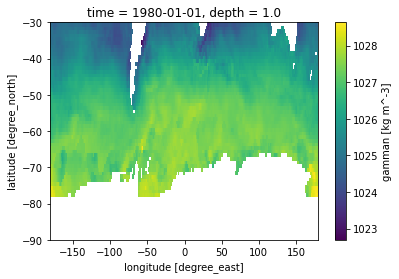

In [37]:
ds['gamman'].isel(time=0,depth=0).plot()

In [35]:
with ProgressBar():
    G.load()

[#################                       ] | 43% Completed | 15.2s

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 34.3s


In [41]:
import matplotlib.pyplot as plt
import so_decadal_variability.calc as socalc

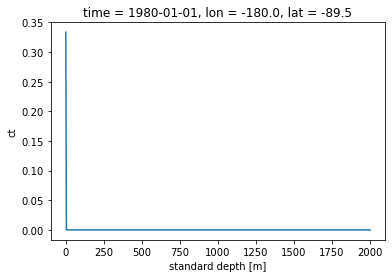

In [51]:
mask = wmt._create_mask(ds)
mask.isel(lon=0,lat=0).plot()
# plt.pcolormesh(socalc._annual(G['total']));

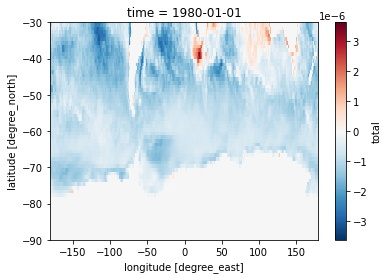

In [59]:
F = wmt.calc_densityflux(ds,xgrid)
F['total'].sum('depth').isel(time=0).plot()

In [55]:
ds['dz']

<xarray.DataArray 'dz' (depth: 41)>
array([  3. ,   4.5,   7.5,  10. ,  10. ,  10. ,  10. ,  10. ,  10. ,
        10. ,  10. ,  15. ,  20. ,  20. ,  20. ,  20. ,  35. ,  50. ,
        50. ,  50. ,  50. ,  50. ,  50. ,  50. ,  50. ,  50. ,  50. ,
        50. ,  50. ,  50. ,  75. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 150. , 200. ])
Coordinates:
  * depth    (depth) float32 1.0 5.0 10.0 20.0 ... 1600.0 1700.0 1800.0 2000.0